# Training on CIFAR-10 data

## Define the model

We now define the `DeepNN` model and several functions that load and prepare the data. Finally, we arrive at the function `setup_and_train`, that defines, trains and evaluates the model, and takes the following parameters as input:

`activation` : Defines activations: CELU, ELU, GELU, LeakyReLU, Maxout, ReLU, ReLU6, RReLU, SELU, Sigmoid, Softplus
    Swish, Tanh, APL, Mixture, PAU, PReLU, SLAF, AReLU

`epochs` : Number of epochs to train

`depth` : Depth of NN

`width` : Width of NN

`lr` : Learning rate

In [1]:
######################################################################
# Import and set manual seed

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import activations

torch.manual_seed(0)

In [9]:
########################################################################
# Download and define the training set.

batchsize = 128
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='/home/densechen/dataset', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)
device = "cuda:0"


########################################################################
#Define input-output Jacobian

def get_jacobian(model, x):
    nc = x.size()[0]
    ny = x.size()[2]
    nx = x.size()[1]
    noutputs = 10
    x = x.reshape(nc*nx*ny)
    x = x.repeat(noutputs,1)
    x.requires_grad_(True)
    y = model(x.reshape(noutputs,nc,nx,ny))
    y.backward(torch.eye(noutputs).to(device))
    return x.grad.data


########################################################################
# Define activation with ELSA
class ELSA(nn.Module):
    def __init__(self, activation: str = "ReLU", with_elsa: bool=False, **kwargs):
        super().__init__()
        self.activation = activations.__class_dict__[activation](**kwargs)
        self.with_elsa = with_elsa
        
        if self.with_elsa:
            self.alpha = nn.Parameter(torch.tensor([kwargs.get("alpha", 0.90)]))
            self.beta = nn.Parameter(torch.tensor([kwargs.get("beta", 2.0)]))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.with_elsa:
            alpha = torch.clamp(self.alpha, min=0.01, max=0.99)
            beta = torch.sigmoid(self.beta)
            
            return self.activation(x) + torch.where(x > 0, x * self.beta, x * self.alpha)
        else:
            return self.activation(x)

########################################################################
# Define fully connected network with different activation functions.

class DeepNN(nn.Module):
    def __init__(self, width: int, depth: int, activation: str="ReLU", with_elsa: bool = False, **kwargs):
        """
            :param width: the width of linear layer.
            :param depth: the depth of linear layer.
            :param activation: the activation used in this layer.
            :param with_elsa: whether with elsa or not.
            :param kwargs: the arguments delivered to activation functions.
        """
        super(DeepNN, self).__init__()
        
        self.linear_input = nn.Linear(3*32*32, width)
        self.activation_input = ELSA(activation, with_elsa=with_elsa, **kwargs)
        
        self.linear_layers = nn.ModuleList([nn.Sequential(nn.Linear(width, width), 
                                                          ELSA(activation, with_elsa=with_elsa, **kwargs))
                                            for i in range(depth)])
        
        self.linear_output = nn.Linear(width, 10)
        
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.activation_input(self.linear_input(x))
        
        for layer in self.linear_layers:
            x = layer(x)
        x = self.linear_output(x)
        return x

def setup_and_train(
    epochs: int=10, lr: float=1e-3, width: int=256, depth: int=2, 
    activation: str = "ReLU", plt_jacobian: bool = True, **kwargs):

    def train(with_elsa: bool = False):
        ######################################################################
        # Model setup
        model = DeepNN(width, depth, activation, with_elsa=with_elsa, **kwargs)
        model.to(device);
        ######################################################################
        # Define criterion and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        ######################################################################
        # Train the model
        model.train()
        for epoch in range(epochs):  # loop over the dataset multiple times
            epoch_start_time = time.time()
            running_loss = 0.0
            log_interval = 100
            for batch, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # print statistics
                running_loss += loss.item()
            cur_loss = running_loss / (batch+1)
            print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f}'.format
                  (epoch+1, (time.time() - epoch_start_time),cur_loss))
            running_loss = 0.
        return model
    
    def gather(model):
        d_collected = list()
        u_collected = list()
        for i in range(100):
            src = torch.randn(3, 32, 32).to(device)
            J = get_jacobian(model,src)
            v, d, u = torch.svd(J.to('cpu'))
            d_collected.append(d.numpy().tolist())
            u_collected.append(u.numpy().tolist())
        d_ = np.asarray(d_collected).flatten()
        y = np.log(d_)/np.log(10)
        return y

    with PdfPages(f"pictures/{activation}.pdf") as pdf:
        # train without elsa
        print("train model without ELSA")
        print("---"*10)
        model = train(with_elsa=False)
        y = gather(model)

        fig, ax = plt.subplots()
        opacity=.7
        plt.ylim((0,4))
        plt.xlim((-4,2))

        ax.hist(y, bins = 10, alpha = opacity, label = activation + " w/o ELSA",
                density = True)

        # train with elsa
        print("\ntrain model with ELSA")
        print("---"*10)
        model = train(with_elsa=True)
        y = gather(model)
        ax.hist(y, bins = 10, alpha = opacity, label = activation + " w/ ELSA",
                density = True)

        ax.legend(loc='upper right')
        ax.set_xlabel(r'$log(\lambda_{io}$)')
        pdf.savefig()
        plt.show()

Files already downloaded and verified


## CELU

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.98s | loss  2.28
| end of epoch   2 | time / epoch  7.03s | loss  2.23
| end of epoch   3 | time / epoch  7.07s | loss  2.18
| end of epoch   4 | time / epoch  6.83s | loss  2.13
| end of epoch   5 | time / epoch  6.91s | loss  2.09
| end of epoch   6 | time / epoch  6.90s | loss  2.05
| end of epoch   7 | time / epoch  7.03s | loss  2.02
| end of epoch   8 | time / epoch  6.98s | loss  2.00
| end of epoch   9 | time / epoch  6.94s | loss  1.98
| end of epoch  10 | time / epoch  7.00s | loss  1.96

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.83s | loss  1.89
| end of epoch   2 | time / epoch  6.88s | loss  1.70
| end of epoch   3 | time / epoch  6.99s | loss  1.63
| end of epoch   4 | time / epoch  7.41s | loss  1.59
| end of epoch   5 | time / epoch  7.15s | loss  1.55
| end of epoch   6 | time / epoch  7.18s | loss  1.52
| end of epoch   7 | time 

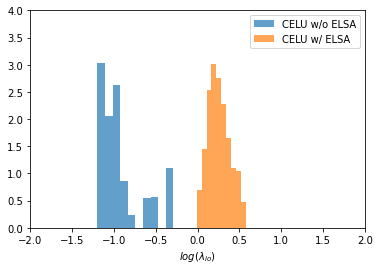

In [3]:
setup_and_train(activation="CELU")

## ELU

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  7.05s | loss  2.28
| end of epoch   2 | time / epoch  6.94s | loss  2.23
| end of epoch   3 | time / epoch  7.07s | loss  2.18
| end of epoch   4 | time / epoch  6.86s | loss  2.13
| end of epoch   5 | time / epoch  7.02s | loss  2.09
| end of epoch   6 | time / epoch  7.05s | loss  2.06
| end of epoch   7 | time / epoch  7.07s | loss  2.03
| end of epoch   8 | time / epoch  6.96s | loss  2.00
| end of epoch   9 | time / epoch  6.90s | loss  1.98
| end of epoch  10 | time / epoch  7.01s | loss  1.96

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.85s | loss  1.90
| end of epoch   2 | time / epoch  7.03s | loss  1.71
| end of epoch   3 | time / epoch  6.87s | loss  1.64
| end of epoch   4 | time / epoch  7.00s | loss  1.59
| end of epoch   5 | time / epoch  7.12s | loss  1.55
| end of epoch   6 | time / epoch  6.86s | loss  1.52
| end of epoch   7 | time 

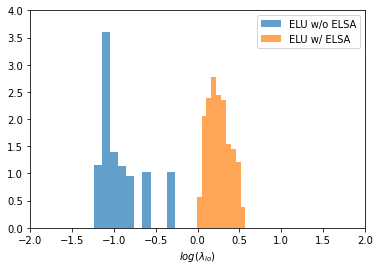

In [4]:
setup_and_train(activation="ELU")

## GELU

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.93s | loss  2.30
| end of epoch   2 | time / epoch  7.08s | loss  2.30
| end of epoch   3 | time / epoch  6.90s | loss  2.30
| end of epoch   4 | time / epoch  7.13s | loss  2.30
| end of epoch   5 | time / epoch  7.16s | loss  2.30
| end of epoch   6 | time / epoch  6.91s | loss  2.29
| end of epoch   7 | time / epoch  7.09s | loss  2.29
| end of epoch   8 | time / epoch  6.99s | loss  2.29
| end of epoch   9 | time / epoch  7.09s | loss  2.29
| end of epoch  10 | time / epoch  6.96s | loss  2.28

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  7.05s | loss  1.95
| end of epoch   2 | time / epoch  7.21s | loss  1.74
| end of epoch   3 | time / epoch  6.97s | loss  1.66
| end of epoch   4 | time / epoch  6.99s | loss  1.61
| end of epoch   5 | time / epoch  7.03s | loss  1.57
| end of epoch   6 | time / epoch  6.83s | loss  1.54
| end of epoch   7 | time 

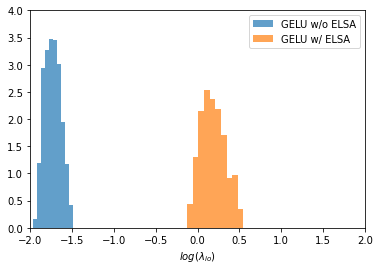

In [5]:
setup_and_train(activation="GELU")

## LeakyReLu

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  7.09s | loss  2.30
| end of epoch   2 | time / epoch  7.11s | loss  2.30
| end of epoch   3 | time / epoch  7.14s | loss  2.29
| end of epoch   4 | time / epoch  7.18s | loss  2.29
| end of epoch   5 | time / epoch  6.99s | loss  2.28
| end of epoch   6 | time / epoch  7.02s | loss  2.28
| end of epoch   7 | time / epoch  7.00s | loss  2.27
| end of epoch   8 | time / epoch  6.98s | loss  2.26
| end of epoch   9 | time / epoch  6.96s | loss  2.25
| end of epoch  10 | time / epoch  7.13s | loss  2.23

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  7.15s | loss  1.92
| end of epoch   2 | time / epoch  6.92s | loss  1.73
| end of epoch   3 | time / epoch  7.06s | loss  1.65
| end of epoch   4 | time / epoch  7.07s | loss  1.60
| end of epoch   5 | time / epoch  6.99s | loss  1.56
| end of epoch   6 | time / epoch  6.92s | loss  1.52
| end of epoch   7 | time 

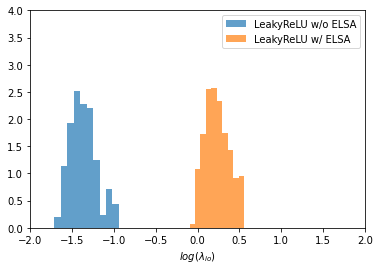

In [6]:
setup_and_train(activation="LeakyReLU")

## Maxout

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  7.52s | loss  2.26
| end of epoch   2 | time / epoch  7.62s | loss  2.18
| end of epoch   3 | time / epoch  7.08s | loss  2.12
| end of epoch   4 | time / epoch  7.11s | loss  2.07
| end of epoch   5 | time / epoch  6.99s | loss  2.03
| end of epoch   6 | time / epoch  7.02s | loss  2.00
| end of epoch   7 | time / epoch  7.04s | loss  1.98
| end of epoch   8 | time / epoch  7.01s | loss  1.96
| end of epoch   9 | time / epoch  7.01s | loss  1.94
| end of epoch  10 | time / epoch  7.12s | loss  1.93

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.97s | loss  1.89
| end of epoch   2 | time / epoch  6.94s | loss  1.73
| end of epoch   3 | time / epoch  7.02s | loss  1.66
| end of epoch   4 | time / epoch  7.10s | loss  1.62
| end of epoch   5 | time / epoch  7.03s | loss  1.58
| end of epoch   6 | time / epoch  6.93s | loss  1.55
| end of epoch   7 | time 

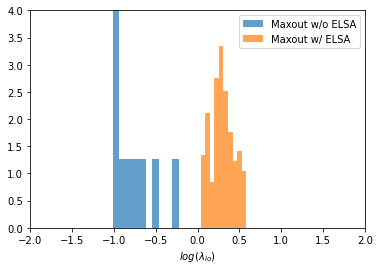

In [7]:
setup_and_train(activation="Maxout")

## ReLU

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.97s | loss  2.30
| end of epoch   2 | time / epoch  6.98s | loss  2.30
| end of epoch   3 | time / epoch  6.91s | loss  2.29
| end of epoch   4 | time / epoch  7.23s | loss  2.29
| end of epoch   5 | time / epoch  7.58s | loss  2.28
| end of epoch   6 | time / epoch  6.90s | loss  2.27
| end of epoch   7 | time / epoch  7.03s | loss  2.27
| end of epoch   8 | time / epoch  6.86s | loss  2.26
| end of epoch   9 | time / epoch  7.02s | loss  2.24
| end of epoch  10 | time / epoch  6.99s | loss  2.23

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.88s | loss  1.94
| end of epoch   2 | time / epoch  7.02s | loss  1.74
| end of epoch   3 | time / epoch  7.01s | loss  1.66
| end of epoch   4 | time / epoch  7.05s | loss  1.60
| end of epoch   5 | time / epoch  6.90s | loss  1.56
| end of epoch   6 | time / epoch  7.06s | loss  1.53
| end of epoch   7 | time 

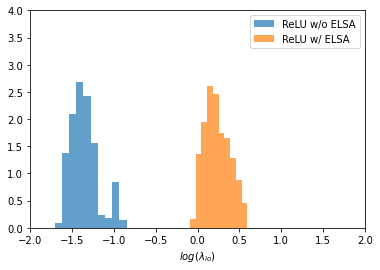

In [8]:
setup_and_train(activation="ReLU")

## ReLU6

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.92s | loss  2.30
| end of epoch   2 | time / epoch  6.86s | loss  2.30
| end of epoch   3 | time / epoch  7.06s | loss  2.29
| end of epoch   4 | time / epoch  6.91s | loss  2.29
| end of epoch   5 | time / epoch  6.75s | loss  2.28
| end of epoch   6 | time / epoch  7.39s | loss  2.27
| end of epoch   7 | time / epoch  7.24s | loss  2.26
| end of epoch   8 | time / epoch  7.22s | loss  2.25
| end of epoch   9 | time / epoch  7.09s | loss  2.24
| end of epoch  10 | time / epoch  7.13s | loss  2.22

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  7.13s | loss  1.92
| end of epoch   2 | time / epoch  7.08s | loss  1.72
| end of epoch   3 | time / epoch  6.85s | loss  1.64
| end of epoch   4 | time / epoch  7.03s | loss  1.59
| end of epoch   5 | time / epoch  7.07s | loss  1.55
| end of epoch   6 | time / epoch  7.04s | loss  1.51
| end of epoch   7 | time 

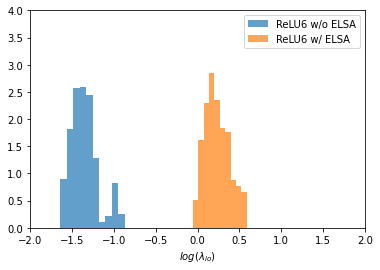

In [9]:
setup_and_train(activation="ReLU6")

## RReLU

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.99s | loss  2.30
| end of epoch   2 | time / epoch  7.02s | loss  2.29
| end of epoch   3 | time / epoch  7.05s | loss  2.28
| end of epoch   4 | time / epoch  7.11s | loss  2.27
| end of epoch   5 | time / epoch  6.89s | loss  2.26
| end of epoch   6 | time / epoch  7.00s | loss  2.24
| end of epoch   7 | time / epoch  7.10s | loss  2.22
| end of epoch   8 | time / epoch  7.57s | loss  2.20
| end of epoch   9 | time / epoch  7.01s | loss  2.18
| end of epoch  10 | time / epoch  7.59s | loss  2.15

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.90s | loss  1.90
| end of epoch   2 | time / epoch  7.12s | loss  1.72
| end of epoch   3 | time / epoch  7.11s | loss  1.64
| end of epoch   4 | time / epoch  7.12s | loss  1.59
| end of epoch   5 | time / epoch  7.04s | loss  1.55
| end of epoch   6 | time / epoch  7.15s | loss  1.52
| end of epoch   7 | time 

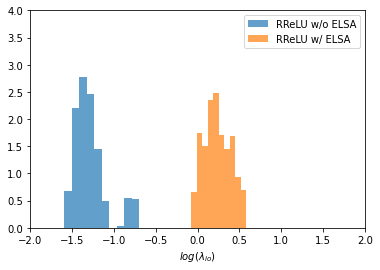

In [10]:
setup_and_train(activation="RReLU")

## SELU

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.97s | loss  2.19
| end of epoch   2 | time / epoch  7.04s | loss  2.06
| end of epoch   3 | time / epoch  6.87s | loss  1.99
| end of epoch   4 | time / epoch  7.00s | loss  1.94
| end of epoch   5 | time / epoch  7.01s | loss  1.91
| end of epoch   6 | time / epoch  7.14s | loss  1.88
| end of epoch   7 | time / epoch  7.04s | loss  1.86
| end of epoch   8 | time / epoch  7.07s | loss  1.85
| end of epoch   9 | time / epoch  6.91s | loss  1.83
| end of epoch  10 | time / epoch  7.58s | loss  1.82

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  7.43s | loss  1.88
| end of epoch   2 | time / epoch  7.41s | loss  1.69
| end of epoch   3 | time / epoch  7.17s | loss  1.62
| end of epoch   4 | time / epoch  7.26s | loss  1.58
| end of epoch   5 | time / epoch  7.07s | loss  1.54
| end of epoch   6 | time / epoch  7.10s | loss  1.51
| end of epoch   7 | time 

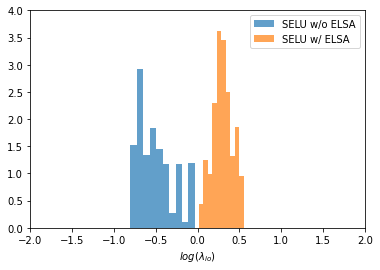

In [11]:
setup_and_train(activation="SELU")

## Sigmoid

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.97s | loss  2.32
| end of epoch   2 | time / epoch  6.95s | loss  2.30
| end of epoch   3 | time / epoch  6.86s | loss  2.30
| end of epoch   4 | time / epoch  6.97s | loss  2.30
| end of epoch   5 | time / epoch  7.02s | loss  2.30
| end of epoch   6 | time / epoch  6.88s | loss  2.30
| end of epoch   7 | time / epoch  6.96s | loss  2.30
| end of epoch   8 | time / epoch  6.90s | loss  2.30
| end of epoch   9 | time / epoch  6.94s | loss  2.30
| end of epoch  10 | time / epoch  7.02s | loss  2.30

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.79s | loss  2.02
| end of epoch   2 | time / epoch  6.97s | loss  1.84
| end of epoch   3 | time / epoch  6.76s | loss  1.78
| end of epoch   4 | time / epoch  7.33s | loss  1.73
| end of epoch   5 | time / epoch  7.40s | loss  1.70
| end of epoch   6 | time / epoch  6.84s | loss  1.67
| end of epoch   7 | time 

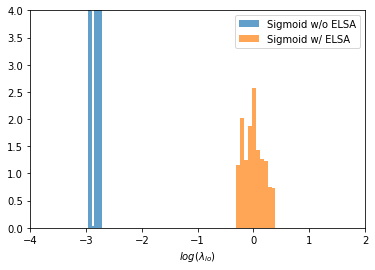

In [10]:
setup_and_train(activation="Sigmoid")

## Softplus

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.91s | loss  2.31
| end of epoch   2 | time / epoch  7.10s | loss  2.30
| end of epoch   3 | time / epoch  7.20s | loss  2.30
| end of epoch   4 | time / epoch  7.03s | loss  2.30
| end of epoch   5 | time / epoch  7.07s | loss  2.30
| end of epoch   6 | time / epoch  7.03s | loss  2.29
| end of epoch   7 | time / epoch  7.05s | loss  2.29
| end of epoch   8 | time / epoch  6.95s | loss  2.29
| end of epoch   9 | time / epoch  7.06s | loss  2.29
| end of epoch  10 | time / epoch  7.13s | loss  2.28

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.99s | loss  1.96
| end of epoch   2 | time / epoch  7.07s | loss  1.78
| end of epoch   3 | time / epoch  7.12s | loss  1.72
| end of epoch   4 | time / epoch  7.86s | loss  1.67
| end of epoch   5 | time / epoch  7.24s | loss  1.63
| end of epoch   6 | time / epoch  7.44s | loss  1.60
| end of epoch   7 | time 

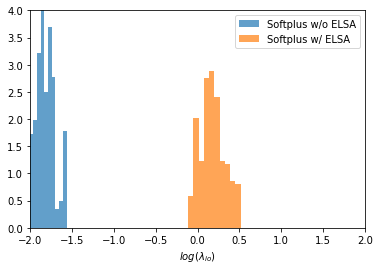

In [13]:
setup_and_train(activation="Softplus")

## Swish

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  7.03s | loss  2.30
| end of epoch   2 | time / epoch  7.31s | loss  2.30
| end of epoch   3 | time / epoch  6.89s | loss  2.30
| end of epoch   4 | time / epoch  7.15s | loss  2.30
| end of epoch   5 | time / epoch  6.99s | loss  2.30
| end of epoch   6 | time / epoch  7.19s | loss  2.29
| end of epoch   7 | time / epoch  6.98s | loss  2.29
| end of epoch   8 | time / epoch  7.06s | loss  2.29
| end of epoch   9 | time / epoch  7.09s | loss  2.29
| end of epoch  10 | time / epoch  6.97s | loss  2.28

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  7.15s | loss  1.95
| end of epoch   2 | time / epoch  7.05s | loss  1.76
| end of epoch   3 | time / epoch  7.02s | loss  1.69
| end of epoch   4 | time / epoch  7.12s | loss  1.64
| end of epoch   5 | time / epoch  7.04s | loss  1.60
| end of epoch   6 | time / epoch  7.47s | loss  1.57
| end of epoch   7 | time 

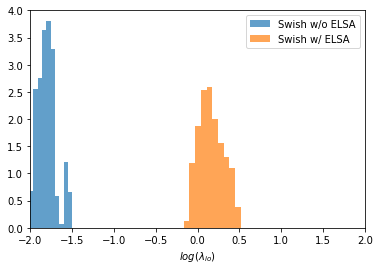

In [14]:
setup_and_train(activation="Swish")

## Tanh

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.94s | loss  2.28
| end of epoch   2 | time / epoch  7.08s | loss  2.23
| end of epoch   3 | time / epoch  6.95s | loss  2.18
| end of epoch   4 | time / epoch  7.13s | loss  2.13
| end of epoch   5 | time / epoch  6.95s | loss  2.09
| end of epoch   6 | time / epoch  6.94s | loss  2.05
| end of epoch   7 | time / epoch  7.10s | loss  2.02
| end of epoch   8 | time / epoch  7.10s | loss  1.99
| end of epoch   9 | time / epoch  7.20s | loss  1.97
| end of epoch  10 | time / epoch  7.18s | loss  1.95

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  7.02s | loss  1.90
| end of epoch   2 | time / epoch  6.98s | loss  1.73
| end of epoch   3 | time / epoch  7.05s | loss  1.67
| end of epoch   4 | time / epoch  7.08s | loss  1.62
| end of epoch   5 | time / epoch  7.10s | loss  1.58
| end of epoch   6 | time / epoch  7.03s | loss  1.55
| end of epoch   7 | time 

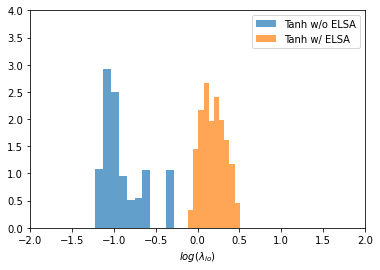

In [15]:
setup_and_train(activation="Tanh")

## APL

train model without ELSA
------------------------------


/home/densechen/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


| end of epoch   1 | time / epoch  7.06s | loss  2.31
| end of epoch   2 | time / epoch  7.07s | loss  2.30
| end of epoch   3 | time / epoch  7.13s | loss  2.30
| end of epoch   4 | time / epoch  7.03s | loss  2.30
| end of epoch   5 | time / epoch  7.04s | loss  2.30
| end of epoch   6 | time / epoch  7.18s | loss  2.30
| end of epoch   7 | time / epoch  6.98s | loss  2.30
| end of epoch   8 | time / epoch  7.09s | loss  2.29
| end of epoch   9 | time / epoch  6.99s | loss  2.29
| end of epoch  10 | time / epoch  7.17s | loss  2.29

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  7.03s | loss  1.97
| end of epoch   2 | time / epoch  7.22s | loss  1.75
| end of epoch   3 | time / epoch  7.01s | loss  1.67
| end of epoch   4 | time / epoch  7.14s | loss  1.61
| end of epoch   5 | time / epoch  7.12s | loss  1.57
| end of epoch   6 | time / epoch  7.07s | loss  1.54
| end of epoch   7 | time / epoch  7.03s | loss  1.51
| end of epoch   8 | time / 

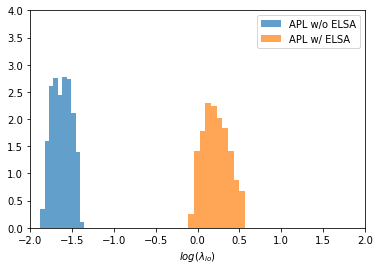

In [16]:
setup_and_train(activation="APL")

## Mixture

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  7.54s | loss  2.30
| end of epoch   2 | time / epoch  7.55s | loss  2.30
| end of epoch   3 | time / epoch  7.11s | loss  2.29
| end of epoch   4 | time / epoch  7.02s | loss  2.29
| end of epoch   5 | time / epoch  6.98s | loss  2.28
| end of epoch   6 | time / epoch  6.96s | loss  2.27
| end of epoch   7 | time / epoch  6.99s | loss  2.26
| end of epoch   8 | time / epoch  7.03s | loss  2.25
| end of epoch   9 | time / epoch  7.16s | loss  2.23
| end of epoch  10 | time / epoch  7.01s | loss  2.21

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  7.10s | loss  1.93
| end of epoch   2 | time / epoch  6.95s | loss  1.73
| end of epoch   3 | time / epoch  7.15s | loss  1.65
| end of epoch   4 | time / epoch  7.04s | loss  1.59
| end of epoch   5 | time / epoch  7.13s | loss  1.55
| end of epoch   6 | time / epoch  7.10s | loss  1.52
| end of epoch   7 | time 

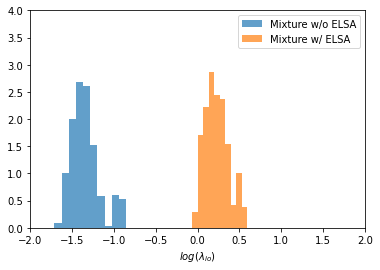

In [17]:
setup_and_train(activation="Mixture")

## PAU

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.96s | loss  2.30
| end of epoch   2 | time / epoch  6.79s | loss  2.30
| end of epoch   3 | time / epoch  6.66s | loss  2.30
| end of epoch   4 | time / epoch  6.73s | loss  2.30
| end of epoch   5 | time / epoch  6.69s | loss  2.29
| end of epoch   6 | time / epoch  6.61s | loss  2.29
| end of epoch   7 | time / epoch  6.80s | loss  2.28
| end of epoch   8 | time / epoch  6.81s | loss  2.28
| end of epoch   9 | time / epoch  6.83s | loss  2.26
| end of epoch  10 | time / epoch  6.61s | loss  2.25

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.62s | loss  1.93
| end of epoch   2 | time / epoch  6.74s | loss  1.72
| end of epoch   3 | time / epoch  6.75s | loss  1.64
| end of epoch   4 | time / epoch  6.76s | loss  1.59
| end of epoch   5 | time / epoch  6.81s | loss  1.55
| end of epoch   6 | time / epoch  6.81s | loss  1.52
| end of epoch   7 | time 

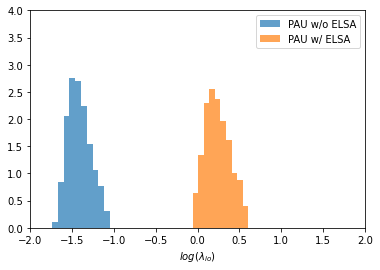

In [4]:
setup_and_train(activation="PAU")

## PReLU

train model without ELSA
------------------------------
| end of epoch   1 | time / epoch  6.78s | loss  2.30
| end of epoch   2 | time / epoch  6.82s | loss  2.29
| end of epoch   3 | time / epoch  7.14s | loss  2.29
| end of epoch   4 | time / epoch  7.26s | loss  2.28
| end of epoch   5 | time / epoch  6.91s | loss  2.26
| end of epoch   6 | time / epoch  6.82s | loss  2.25
| end of epoch   7 | time / epoch  6.83s | loss  2.23
| end of epoch   8 | time / epoch  7.01s | loss  2.20
| end of epoch   9 | time / epoch  6.85s | loss  2.17
| end of epoch  10 | time / epoch  6.93s | loss  2.15

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.81s | loss  1.93
| end of epoch   2 | time / epoch  6.85s | loss  1.72
| end of epoch   3 | time / epoch  6.89s | loss  1.65
| end of epoch   4 | time / epoch  7.03s | loss  1.59
| end of epoch   5 | time / epoch  6.79s | loss  1.56
| end of epoch   6 | time / epoch  7.00s | loss  1.52
| end of epoch   7 | time 

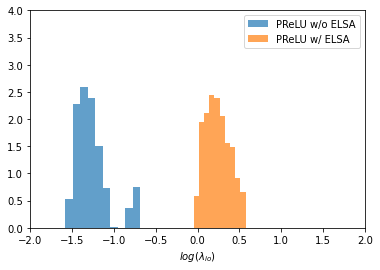

In [5]:
setup_and_train(activation="PReLU")

## SLAF

train model without ELSA
------------------------------


/home/densechen/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


| end of epoch   1 | time / epoch  6.73s | loss  2.26
| end of epoch   2 | time / epoch  6.81s | loss  2.18
| end of epoch   3 | time / epoch  6.92s | loss  2.09
| end of epoch   4 | time / epoch  6.73s | loss  2.02
| end of epoch   5 | time / epoch  6.76s | loss  1.97
| end of epoch   6 | time / epoch  6.83s | loss  1.93
| end of epoch   7 | time / epoch  7.28s | loss  1.90
| end of epoch   8 | time / epoch  6.81s | loss  1.88
| end of epoch   9 | time / epoch  7.49s | loss  1.86
| end of epoch  10 | time / epoch  6.94s | loss  1.84

train model with ELSA
------------------------------
| end of epoch   1 | time / epoch  6.73s | loss  1.92
| end of epoch   2 | time / epoch  6.96s | loss  1.74
| end of epoch   3 | time / epoch  6.84s | loss  1.68
| end of epoch   4 | time / epoch  6.93s | loss  1.64
| end of epoch   5 | time / epoch  6.83s | loss  1.60
| end of epoch   6 | time / epoch  6.86s | loss  1.57
| end of epoch   7 | time / epoch  6.98s | loss  1.55
| end of epoch   8 | time / 

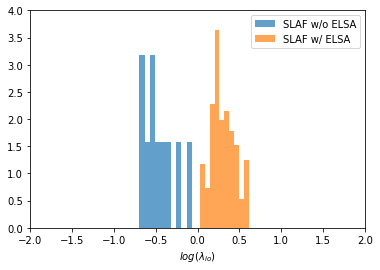

In [6]:
setup_and_train(activation="SLAF")